In [283]:
!pwd

/Users/nadirgmira/code/carbon-forecast/notebooks


In [2]:
import sys
sys.path
sys.path.append('/Users/nadirgmira/code/carbon-forecast')

In [3]:
%load_ext autoreload
%autoreload 2

In [17]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.options.display.max_info_columns=500
pd.options.display.max_info_rows=550

from sklearn import set_config; set_config(display='diagram')
from sklearn.cluster import KMeans
from carbon_forecast.utils.tx import our_tx
from carbon_forecast.utils.preproc import (load_n_preproc_all_avail,
                                           load_n_preproc )

from sklearn.cluster import KMeans
import pickle
import os
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from carbon_forecast.utils.tx import our_tx

Create a dataframe with TCUID,Company,Sector,Carbon Intensity, Climate Score, Carbon Emission

In [346]:
!pwd

/Users/nadirgmira/code/carbon-forecast/notebooks


In [7]:
y=2020

dg=pd.read_csv("/Users/nadirgmira/code/carbon-forecast/raw_data/Historical_Emissions.csv")
dg=dg[dg['Financial Year']==2020][['Carbon-Scope 1 (tonnes CO2e)',
                                                     'Carbon-Scope 2 (tonnes CO2e)','TCUID']]
dg=dg.set_index('TCUID')


In [9]:
year=2020
df = load_n_preproc(year)

Reading data...
Preproc on power % revenue
Preproc on Sector Revenue
Selecting the year 2020 required...
Dropping rows that are showing NaN on...
-> intensity_scope1CY2020
-> intensity_scope2CY2020
-> intensity_scope3CY2020
-> Revenue2020
Filling employee numbers with mean value... (subject to change later)
Filling EV with mean value... (subject to change later)
Calculating Employees & EV per Revenue...
Filling null Climate Strategy Score with 0...
Cleaning P/E Ratio...
Adding Scope 1 and Scope 2 data together...
Doing some column renaming...
Filling in Disclosure...
Dataset preproc-ed for the year 2020!👍


In [49]:
df.columns.tolist()

['company_name',
 'TCUID',
 'year',
 'Sector',
 'Employees / Revenue',
 'EV / Revenue',
 'climate_strategy_score',
 'disclosure',
 'intensity_1and2',
 'intensity_scope3',
 'pe_rat',
 'revenue',
 'nuclear_percentage_revenue',
 'thermal_coal_percentage_revenue',
 'ultra_deep_sea_drilling_percentage_revenue',
 'shale_oil_gas_percentage_revenue',
 'coal_percentage_revenue',
 'arctic_drilling_percentage_revenue',
 'oil_sands_percentage_revenue',
 'Abrasive product manufacturing',
 'Accounting, tax preparation, bookkeeping, and payroll services',
 'Adhesive manufacturing',
 'Advertising and related services',
 'Air and gas compressor manufacturing',
 'Air conditioning, refrigeration, and warm air heating equipment manufacturing',
 'Air purification and ventilation equipment manufacturing',
 'Air transportation',
 'Aircraft engine and engine parts manufacturing',
 'Aircraft manufacturing',
 'Alkalies and chlorine manufacturing',
 'All other basic inorganic chemical manufacturing',
 'All other

In [50]:
Y_original=df[["TCUID"
,"company_name",'Sector',"intensity_1and2","climate_strategy_score","revenue"]].set_index('TCUID')

Y_original




,company_name,Sector,intensity_1and2,climate_strategy_score,revenue
TCUID,,,,,
185037.0,"""Bank ""Saint-Petersburg"" Public Joint-Stock Co...",Financials,1.731,0.0,409.268900
236994.0,"&Do Holdings Co.,Ltd. (TSE:3457)",Consumer Discretionary,63.284,0.0,304.026312
185334.0,1&1 AG (XTRA:1U1),Communication Services,17.204,8.0,4315.923668
203522.0,1000mercis (ENXTPA:ALMIL),Communication Services,19.725,0.0,68.428373
244864.0,"10x Genomics, Inc. (NASDAQGS:TXG)",Health Care,38.315,0.0,298.845010
...,...,...,...,...,...
135872.0,Zydus Lifesciences Limited (NSEI:ZYDUSLIFE),Health Care,58.445,0.0,2010.788229
232457.0,Zydus Wellness Limited (BSE:531335),Consumer Staples,101.888,0.0,249.258111
247962.0,Zymergen Inc. (NASDAQGS:ZY),Materials,34.919,0.0,13.284000


In [51]:
Z_original=Y_original.join(dg,on='TCUID')

Z_original['Carbon Outright']=Z_original['Carbon-Scope 1 (tonnes CO2e)']
+Z_original['Carbon-Scope 2 (tonnes CO2e)']

Z_original=Z_original.drop(columns=['Carbon-Scope 1 (tonnes CO2e)','Carbon-Scope 2 (tonnes CO2e)'])

Z_original=Z_original.rename(columns={'intensity_1and2':'Carbon Intensity'})

Z_original.head(3)

,company_name,Sector,Carbon Intensity,climate_strategy_score,revenue,Carbon Outright
TCUID,,,,,,
185037.0,"""Bank ""Saint-Petersburg"" Public Joint-Stock Co...",Financials,1.731,0.0,409.268900,301.933
236994.0,"&Do Holdings Co.,Ltd. (TSE:3457)",Consumer Discretionary,63.284,0.0,304.026312,3970.025
185334.0,1&1 AG (XTRA:1U1),Communication Services,17.204,8.0,4315.923668,22617.631


In [38]:
Z=Z_original[["Carbon Intensity","climate_strategy_score","Carbon Outright"]]

In [15]:
Z

,Carbon Intensity,climate_strategy_score,Carbon Outright
TCUID,,,
185037.0,1.731,0.0,301.933
236994.0,63.284,0.0,3970.025
185334.0,17.204,8.0,22617.631
203522.0,19.725,0.0,514.529
244864.0,38.315,0.0,5356.017
...,...,...,...
135872.0,58.445,0.0,93537.624
232457.0,101.888,0.0,12025.492
247962.0,34.919,0.0,185.279


Histogram of the 3 main metrics

In [39]:
Z=Z[Z['Carbon Outright']>0]

In [40]:
Z.head(3)

,Carbon Intensity,climate_strategy_score,Carbon Outright
TCUID,,,
185037.0,1.731,0.0,301.933
236994.0,63.284,0.0,3970.025
185334.0,17.204,8.0,22617.631


<AxesSubplot:xlabel='climate_strategy_score', ylabel='Count'>

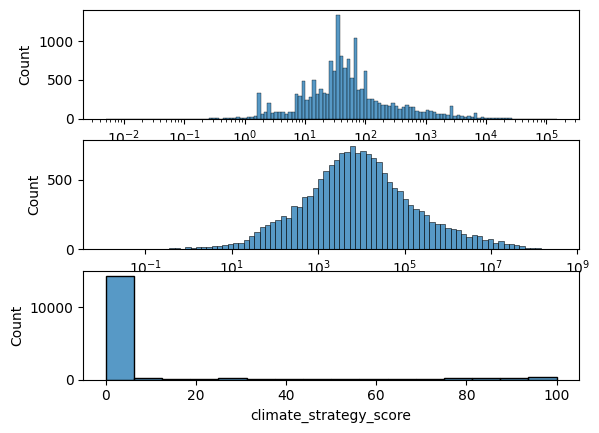

In [42]:
fig,axes=plt.subplots(3)

sns.histplot(Z,x='Carbon Intensity',ax=axes[0],log_scale=True)
sns.histplot(Z,x='Carbon Outright',ax=axes[1],log_scale=True)
sns.histplot(Z,x='climate_strategy_score',ax=axes[2])

In [52]:
Z_original['Carbon Intensity Qtile']=pd.qcut(Z_original['Carbon Intensity'],10, labels=False,
                                            duplicates='drop')

Z_original['Carbon Outright Qtile']=pd.qcut(Z_original['Carbon Outright'],10, labels=False,
                                           duplicates='drop')

Z_original['climate_strategy_score Qtile']=pd.qcut(Z_original['climate_strategy_score'],
                                                   10, labels=False,
                                                  duplicates='drop')

Z_original.head(3)

,company_name,Sector,Carbon Intensity,climate_strategy_score,revenue,Carbon Outright,Carbon Intensity Qtile,Carbon Outright Qtile,climate_strategy_score Qtile
TCUID,,,,,,,,,
185037.0,"""Bank ""Saint-Petersburg"" Public Joint-Stock Co...",Financials,1.731,0.0,409.268900,301.933,0,1,0
236994.0,"&Do Holdings Co.,Ltd. (TSE:3457)",Consumer Discretionary,63.284,0.0,304.026312,3970.025,6,3,0
185334.0,1&1 AG (XTRA:1U1),Communication Services,17.204,8.0,4315.923668,22617.631,2,6,0


In [45]:
Z_original['Sector'].unique()

array(['Financials', 'Consumer Discretionary', 'Communication Services',
       'Health Care', 'Consumer Staples', 'Industrials',
       'Information Technology', 'Real Estate', 'Materials', 'Utilities',
       'Energy'], dtype=object)

In [54]:
Z_strats_intens=Z_original[['company_name','Sector','Carbon Intensity',
                                       'Carbon Intensity Qtile','revenue']].sort_values(by='revenue',ascending=False).groupby(
                                ['Carbon Intensity Qtile','Sector']).agg({'Carbon Intensity':'mean'
                                            ,'company_name':['count','first'],
                                                                          
                                                                })

Z_strats_intens



Carbon Intensity company_name  \
                                                          mean        count   
Carbon Intensity Qtile Sector                                                 
0                      Communication Services         3.958269           70   
                       Consumer Discretionary         4.471397           78   
                       Consumer Staples               5.517400           15   
                       Energy                         5.215556            9   
                       Financials                     3.473980         1257   
...                                                        ...          ...   
9                      Industrials                 2280.327822          263   
                       Information Technology      5200.629581           36   
                       Materials                   2656.120735          685   
                       Real Estate                  907.071613           31   
                       Utilities                   5370.351328          212   

                                                                                                  
                                                                                           first  
Carbon Intensity Qtile Sector                                                                     
0                      Communication Services       Charter Communications, Inc. (NASDAQGS:CHTR)  
                       Consumer Discretionary  LVMH Moët Hennessy - Louis Vuitton, Société Eu...  
                       Consumer Staples                           George Weston Limited (TSX:WN)  
                       Energy                         World Fuel Services Corporation (NYSE:INT)  
                       Financials              Ping An Insurance (Group) Company of China, Lt...  
...                                                                                          ...  
9                      Industrials                                      CITIC Limited (SEHK:267)  
                       Information Technology  BOE Technology Group Company Limited (SZSE:000...  
                       Materials                             Nippon Steel Corporation (TSE:5401)  
                       Real Estate                               Swire Pacific Limited (SEHK:19)  
                       Utilities                                             Enel SpA (BIT:ENEL)  

[110 rows x 3 columns]

In [56]:
dn=Z_strats_intens.xs('Health Care',level='Sector')
dn

Carbon Intensity company_name  \
                                   mean        count   
Carbon Intensity Qtile                                 
0                              3.253268           41   
1                             10.839841           96   
2                             19.834051          107   
3                             29.024510          471   
4                             37.154286          614   
5                             49.059848          162   
6                             65.271576           55   
7                            111.198553           38   
8                            256.910660           47   
9                           3827.490444           18   

                                                                           
                                                                    first  
Carbon Intensity Qtile                                                     
0                                       CVS Health Corporation (NYSE:CVS)  
1                                            Johnson & Johnson (NYSE:JNJ)  
2                                                  Novartis AG (SWX:NOVN)  
3                                                       GSK plc (LSE:GSK)  
4                                      Fresenius SE & Co. KGaA (XTRA:FRE)  
5                                         HCA Healthcare, Inc. (NYSE:HCA)  
6                                    Bayer Aktiengesellschaft (XTRA:BAYN)  
7                       MERCK Kommanditgesellschaft auf Aktien (XTRA:MRK)  
8                                               Avantor, Inc. (NYSE:AVTR)  
9                       Sichuan Kelun Pharmaceutical Co., Ltd. (SZSE:0...

In [48]:
import os
path="/Users/nadirgmira/code/carbon-forecast/carbon_forecast/pickle"


name= os.path.join(path,"benchmark_frame.pkl")
with open(name, "wb") as file:
    Z_strats_intens.to_pickle(name)
    
    
name= os.path.join(path,"benchmark_healthcare_frame.pkl")
with open(name, "wb") as file:
    Z_strats_intens.xs('Health Care',level='Sector').xs('Health Care',level='Sector').to_pickle(name)
        

<AxesSubplot:>

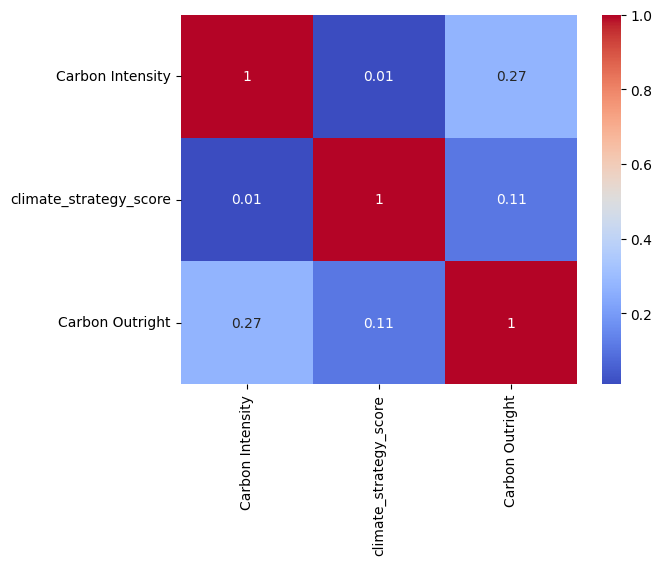

In [377]:

sns.heatmap(round(Z.corr(),2), cmap = "coolwarm", 
            annot = True)

In [30]:
Z_original.columns

Index(['company_name', 'Sector', 'Carbon Intensity', 'climate_strategy_score',
       'Carbon Outright', 'Carbon Intensity Qtile', 'Carbon Outright Qtile',
       'climate_strategy_score Qtile'],
      dtype='object')

<AxesSubplot:xlabel='Carbon Intensity', ylabel='climate_strategy_score'>

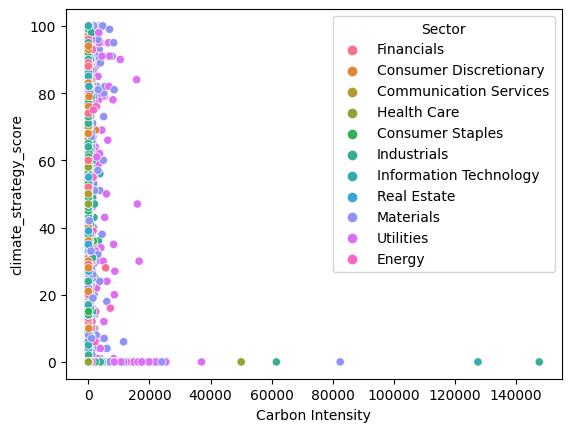

In [32]:
sns.scatterplot(data=Z_original, x="Carbon Intensity", y="climate_strategy_score",hue="Sector")


<AxesSubplot:xlabel='Carbon Outright', ylabel='Carbon Intensity'>

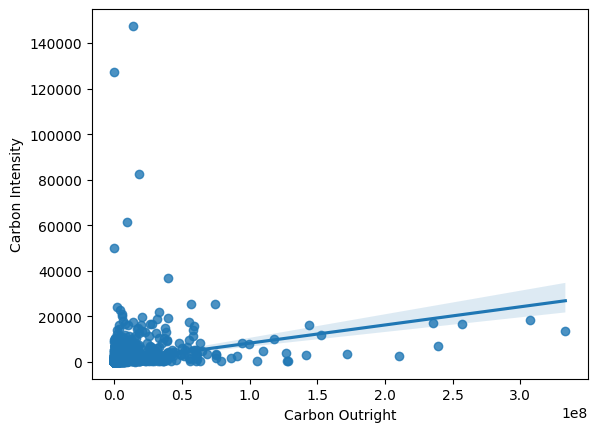

In [374]:
sns.regplot(data=Z, x="Carbon Outright", y="Carbon Intensity")


In [378]:
!pip install statsmodels

In [382]:
Z.columns

Index(['Carbon Intensity', 'climate_strategy_score', 'Carbon Outright'], dtype='object')

In [394]:
Z.head(3)

,Carbon Intensity,climate_strategy_score,Carbon Outright
TCUID,,,
185037.0,1.731,0.0,301.933
236994.0,63.284,0.0,3970.025
185334.0,17.204,8.0,22617.631


In [397]:

from sklearn.linear_model import LinearRegression

model_reg = LinearRegression()

X=Z[['Carbon Intensity','Carbon Outright']]
y=Z['climate_strategy_score']

model_reg .fit(X, y)

print(model_reg.coef_)
print(model_reg.score(X,y))


[-2.73352377e-04  3.55149401e-07]
0.012513285447011913


In [371]:
km_intro_v1=KMeans(n_clusters=3).fit(Z)

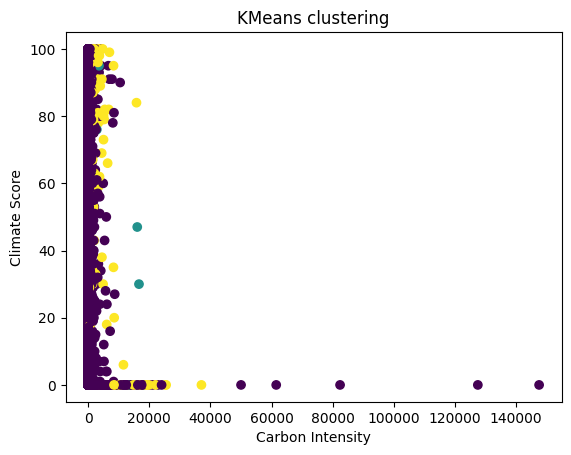

In [372]:
plt.scatter(Z.drop(columns=['Carbon Outright']).iloc[:,0], Z.drop(columns=['Carbon Outright']).iloc[:,1]
            , c=km_intro_v1.labels_)

plt.title('KMeans clustering'); plt.xlabel('Carbon Intensity'); plt.ylabel('Climate Score');



In [368]:
km_intro=KMeans(n_clusters=3).fit(Z.drop(columns=['Carbon Outright']))

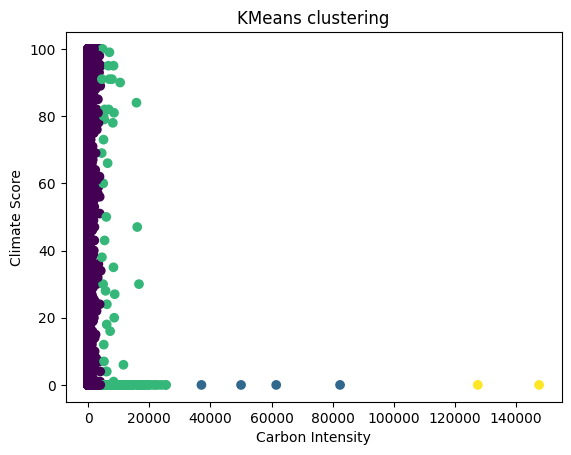

In [370]:
plt.scatter(Z.drop(columns=['Carbon Outright']).iloc[:,0], Z.drop(columns=['Carbon Outright']).iloc[:,1]
            , c=km_intro.labels_)

plt.title('KMeans clustering'); plt.xlabel('Carbon Intensity'); plt.ylabel('Climate Score');


Text(0.5, 0, 'k cluster number')

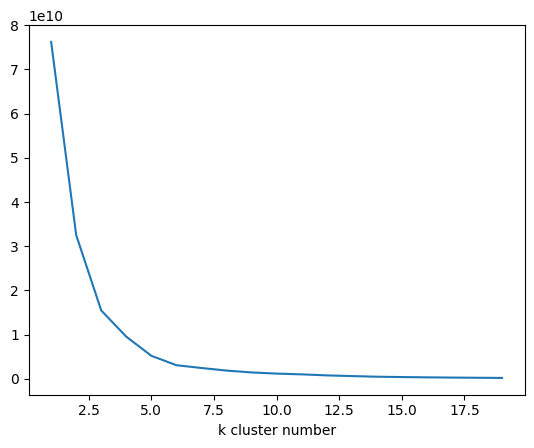

In [366]:
inertias_intro = []
ks = range(1,20)

for k in ks:
    km_test_intro = KMeans(n_clusters=k).fit(Z.drop(columns=['Carbon Outright']))
    inertias_intro.append(km_test_intro.inertia_)

plt.plot(ks, inertias_intro)
plt.xlabel('k cluster number')



In [286]:
! ls /Users/nadirgmira/code/carbon-forecast/carbon_forecast/pickle

col_transf.pkl   kmeans.pkl       pca.pkl
encoder.pkl      minmax.pkl       xgboost_d5_model


In [287]:
year=2020
df = load_n_preproc(year)
X = df.drop(columns=["company_name","year", "intensity_1and2","intensity_scope3",
                     "climate_strategy_score","disclosure","EV / Revenue","pe_rat"])
X=X.set_index('TCUID')
X

Reading data...
Preproc on power % revenue
Preproc on Sector Revenue
Selecting the year 2020 required...
Dropping rows that are showing NaN on...
-> intensity_scope1CY2020
-> intensity_scope2CY2020
-> intensity_scope3CY2020
-> Revenue2020
Filling employee numbers with mean value... (subject to change later)
Filling EV with mean value... (subject to change later)
Calculating Employees & EV per Revenue...
Filling null Climate Strategy Score with 0...
Cleaning P/E Ratio...
Adding Scope 1 and Scope 2 data together...
Doing some column renaming...
Filling in Disclosure...
Dataset preproc-ed for the year 2020!👍


,Sector,Employees / Revenue,revenue,nuclear_percentage_revenue,thermal_coal_percentage_revenue,ultra_deep_sea_drilling_percentage_revenue,shale_oil_gas_percentage_revenue,coal_percentage_revenue,arctic_drilling_percentage_revenue,oil_sands_percentage_revenue,Abrasive product manufacturing,"Accounting, tax preparation, bookkeeping, and payroll services",Adhesive manufacturing,Advertising and related services,Air and gas compressor manufacturing,"Air conditioning, refrigeration, and warm air heating equipment manufacturing",Air purification and ventilation equipment manufacturing,Air transportation,Aircraft engine and engine parts manufacturing,Aircraft manufacturing,Alkalies and chlorine manufacturing,All other basic inorganic chemical manufacturing,All other chemical product and preparation manufacturing,All other converted paper product manufacturing,All other crop farming,All other food manufacturing,"All other forging, stamping, and sintering",All other miscellaneous electrical equipment and component manufacturing,All other miscellaneous manufacturing,"All other miscellaneous professional, scientific, and technical services",All other miscellaneous wood product manufacturing,All other paper bag and coated and treated paper manufacturing,All other petroleum and coal products manufacturing,All other textile product mills,All other transportation equipment manufacturing,Alumina refining and primary aluminum production,Aluminum product manufacturing from purchased aluminum,Ammunition manufacturing,"Amusement parks, arcades, and gambling industries",Analytical laboratory instrument manufacturing,"Animal (except poultry) slaughtering, rendering, and processing","Animal production, except cattle and poultry and eggs",Apparel accessories and other apparel manufacturing,Apparel knitting mills,"Apparel, Piece Goods, and Notions Wholesalers","Architectural, engineering, and related services","Arms, ordnance, and accessories manufacturing",Artificial and synthetic fibers and filaments manufacturing,Asphalt paving mixture and block manufacturing,Asphalt shingle and coating materials manufacturing,Audio and video equipment manufacturing,Automatic environmental control manufacturing,Automobile manufacturing,Automotive equipment rental and leasing,"Automotive repair and maintenance, except car washes",Ball and roller bearing manufacturing,Bare printed circuit board manufacturing,Bauxite Mining,Beet sugar manufacturing,Biological product (except diagnostic) manufacturing,Biomass Power Generation,Bituminous Coal Underground Mining,Bituminous Coal and Lignite Surface Mining,Blind and shade manufacturing,Boat building,Book publishers,Bowling centers,Bread and bakery product manufacturing,Breakfast cereal manufacturing,Breweries,"Brick, tile, and other structural clay product manufacturing",Broadcast and wireless communications equipment,Broadwoven fabric mills,"Broom, brush, and mop manufacturing",Building Material and Garden Equipment and Supplies Dealers,Business support services,Cable and other subscription programming,Car washes,Carbon and graphite product manufacturing,Carbon black manufacturing,Carpet and rug mills,Cattle ranching and farming,Cement manufacturing,Cheese manufacturing,Child day care services,Chocolate and confectionery manufacturing from cacao beans,Clay and nonclay refractory manufacturing,Clothing and Clothing Accessories Stores,Coal Power Generation,"Coated and laminated paper, packaging paper and plastics film manufacturing","Coating, engraving, heat treating and allied activities",Coffee and tea manufacturing,Commercial and industrial machinery and equipment rental and leasing,Commercial and industrial machinery and equipment repair and maintenance,Communication and energy wire and cable manufacturing,"Community food, housing, and other relief services, including rehabilitation services",Computer storage device manufacturing,Computer systems design services,Computer terminals and other computer peripheral equipment 

In [288]:
model=our_tx(X)

In [289]:
model

ColumnTransformer(transformers=[('num_tr', MinMaxScaler(),
                                 ['Abrasive product manufacturing',
                                  'Accounting, tax preparation, bookkeeping, '
                                  'and payroll services',
                                  'Adhesive manufacturing',
                                  'Advertising and related services',
                                  'Air and gas compressor manufacturing',
                                  'Air conditioning, refrigeration, and warm '
                                  'air heating equipment manufacturing',
                                  'Air purification and ventilation equip...
                                  'All other textile product mills',
                                  'All other transportation equipment '
                                  'manufacturing',
                                  'Alumina refining and primary aluminum '
                                  'production',
                                  'Aluminum product manufacturing from '
                                  'purchased aluminum',
                                  'Ammunition manufacturing',
                                  'Amusement parks, arcades, and gambling '
                                  'industries',
                                  'Analytical laboratory instrument '
                                  'manufacturing', ...]),
                                ('cat_tr',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Sector'])])

In [290]:
model.fit(X)

ColumnTransformer(transformers=[('num_tr', MinMaxScaler(),
                                 ['Abrasive product manufacturing',
                                  'Accounting, tax preparation, bookkeeping, '
                                  'and payroll services',
                                  'Adhesive manufacturing',
                                  'Advertising and related services',
                                  'Air and gas compressor manufacturing',
                                  'Air conditioning, refrigeration, and warm '
                                  'air heating equipment manufacturing',
                                  'Air purification and ventilation equip...
                                  'All other textile product mills',
                                  'All other transportation equipment '
                                  'manufacturing',
                                  'Alumina refining and primary aluminum '
                                  'production',
                                  'Aluminum product manufacturing from '
                                  'purchased aluminum',
                                  'Ammunition manufacturing',
                                  'Amusement parks, arcades, and gambling '
                                  'industries',
                                  'Analytical laboratory instrument '
                                  'manufacturing', ...]),
                                ('cat_tr',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Sector'])])

In [271]:
!pwd

/Users/nadirgmira/code/carbon-forecast/notebooks


In [206]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.options.display.max_info_columns=500
pd.options.display.max_info_rows=550

from sklearn import set_config; set_config(display='diagram')
from sklearn.cluster import KMeans
from carbon_forecast.utils.tx import our_tx
from carbon_forecast.utils.preproc import (load_n_preproc_all_avail,
                                           load_n_preproc )



In [166]:
year=2020
df = load_n_preproc(year)

Reading data...
Preproc on power % revenue
Preproc on Sector Revenue
Selecting the year 2020 required...
Dropping rows that are showing NaN on...
-> intensity_scope1CY2020
-> intensity_scope2CY2020
-> intensity_scope3CY2020
-> Revenue2020
Filling employee numbers with mean value... (subject to change later)
Filling EV with mean value... (subject to change later)
Calculating Employees & EV per Revenue...
Filling null Climate Strategy Score with 0...
Cleaning P/E Ratio...
Adding Scope 1 and Scope 2 data together...
Doing some column renaming...
Filling in Disclosure...
Dataset preproc-ed for the year 2020!👍


In [207]:
X = df.drop(columns=["company_name","year", "intensity_1and2","intensity_scope3",
                     "climate_strategy_score","disclosure","EV / Revenue","pe_rat"])
X=X.set_index('TCUID')

In [329]:
df.columns

Index(['company_name', 'TCUID', 'year', 'Sector', 'Employees / Revenue',
       'EV / Revenue', 'climate_strategy_score', 'disclosure',
       'intensity_1and2', 'intensity_scope3',
       ...
       'Water, sewage and other systems', 'Wave & Tidal Power Generation',
       'Wet corn milling', 'Wind Power Generation', 'Wineries',
       'Wiring device manufacturing',
       'Women's and girls' cut and sew apparel manufacturing',
       'Wood container and pallet manufacturing',
       'Wood kitchen cabinet and countertop manufacturing',
       'Wood windows and doors and millwork'],
      dtype='object', length=463)

In [330]:
Y=df[["intensity_1and2","TCUID","company_name"]]
Y=Y.set_index('TCUID')
Y=Y.sort_values(by='intensity_1and2')
Y

,intensity_1and2,company_name
TCUID,,
138181.0,0.005,"Taiwan Cooperative Financial Holding Co., Ltd...."
43642.0,0.017,Storebrand ASA (OB:STB)
54685.0,0.020,Wheaton Precious Metals Corp. (TSX:WPM)
247827.0,0.023,Theme International Holdings Limited (SEHK:990)
177537.0,0.039,Just Group plc (LSE:JUST)
...,...,...
232730.0,50010.458,GlycoNex Incorporation (TPEX:4168)
185566.0,61518.974,Alarko Holding A.S. (IBSE:ALARK)
232245.0,82413.026,Shinwha Intertek Corp. (KOSDAQ:A056700)


In [334]:
X=np.arange(1,20)*0.05
X

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [336]:
Quantile=Y['intensity_1and2'].quantile(np.arange(1,20)*0.05)
Quantile

0.05       2.613000
0.10       7.579000
0.15       9.825400
0.20      14.298000
0.25      19.072500
0.30      26.659600
0.35      29.974649
0.40      34.233000
0.45      37.034000
0.50      42.339000
0.55      49.950800
0.60      57.802600
0.65      68.141000
0.70      79.897200
0.75     103.355000
0.80     143.061400
0.85     259.833800
0.90     496.703000
0.95    1318.882200
Name: intensity_1and2, dtype: float64

<AxesSubplot:xlabel='intensity_1and2', ylabel='Count'>

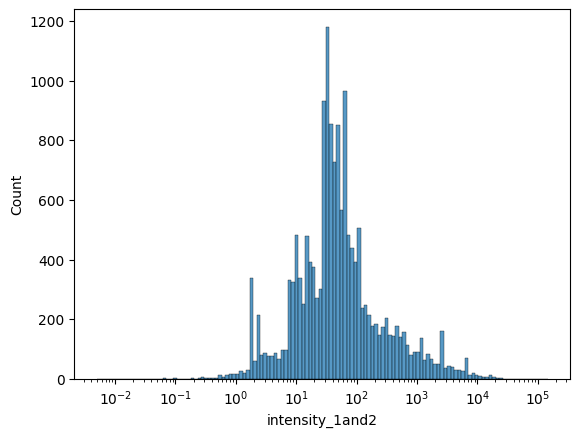

In [342]:
sns.histplot(Y,x="intensity_1and2",log_scale=True)


In [209]:
X.columns.tolist()

['Sector',
 'Employees / Revenue',
 'revenue',
 'nuclear_percentage_revenue',
 'thermal_coal_percentage_revenue',
 'ultra_deep_sea_drilling_percentage_revenue',
 'shale_oil_gas_percentage_revenue',
 'coal_percentage_revenue',
 'arctic_drilling_percentage_revenue',
 'oil_sands_percentage_revenue',
 'Abrasive product manufacturing',
 'Accounting, tax preparation, bookkeeping, and payroll services',
 'Adhesive manufacturing',
 'Advertising and related services',
 'Air and gas compressor manufacturing',
 'Air conditioning, refrigeration, and warm air heating equipment manufacturing',
 'Air purification and ventilation equipment manufacturing',
 'Air transportation',
 'Aircraft engine and engine parts manufacturing',
 'Aircraft manufacturing',
 'Alkalies and chlorine manufacturing',
 'All other basic inorganic chemical manufacturing',
 'All other chemical product and preparation manufacturing',
 'All other converted paper product manufacturing',
 'All other crop farming',
 'All other food m

In [170]:
list(X['Sector'].unique())

['Financials',
 'Consumer Discretionary',
 'Communication Services',
 'Health Care',
 'Consumer Staples',
 'Industrials',
 'Information Technology',
 'Real Estate',
 'Materials',
 'Utilities',
 'Energy']

In [171]:
# l=set(X['Sector']).union(set(X.columns.drop('Sector')))
l=list(X['Sector'].unique())+list(X.columns.drop('Sector'))
l

['Financials',
 'Consumer Discretionary',
 'Communication Services',
 'Health Care',
 'Consumer Staples',
 'Industrials',
 'Information Technology',
 'Real Estate',
 'Materials',
 'Utilities',
 'Energy',
 'Employees / Revenue',
 'revenue',
 'nuclear_percentage_revenue',
 'thermal_coal_percentage_revenue',
 'ultra_deep_sea_drilling_percentage_revenue',
 'shale_oil_gas_percentage_revenue',
 'coal_percentage_revenue',
 'arctic_drilling_percentage_revenue',
 'oil_sands_percentage_revenue',
 'Abrasive product manufacturing',
 'Accounting, tax preparation, bookkeeping, and payroll services',
 'Adhesive manufacturing',
 'Advertising and related services',
 'Air and gas compressor manufacturing',
 'Air conditioning, refrigeration, and warm air heating equipment manufacturing',
 'Air purification and ventilation equipment manufacturing',
 'Air transportation',
 'Aircraft engine and engine parts manufacturing',
 'Aircraft manufacturing',
 'Alkalies and chlorine manufacturing',
 'All other basic 

In [295]:

transformer = our_tx(X)
X_proc=transformer.fit_transform(X)

col=[s.strip("num_tr__").strip("cat_tr__") for s in transformer.get_feature_names_out()]
# columns=transformer.get_feature_names_out().str.strip(["num_tr__","cat_tr__"])
columns

dX_proc=pd.DataFrame(X_proc,columns=col,index=X.index)

dX_proc

,Abrasive product manufacturing,"Accounting, tax preparation, bookkeeping, and payroll services",Adhesive manufacturing,Advertising and related services,Air and gas compressor manufacturing,"Air conditioning, refrigeration, and warm air heating equipment manufacturing",Air purification and ventilation equipment manufacturing,Air transportatio,Aircraft engine and engine parts manufacturing,Aircraft manufacturing,Alkalies and chlorine manufacturing,All other basic inorganic chemical manufacturing,All other chemical product and preparation manufacturing,All other converted paper product manufacturing,All other crop farming,All other food manufacturing,"All other forging, stamping, and sintering",All other miscellaneous electrical equipment and component manufacturing,All other miscellaneous manufacturing,"All other miscellaneous professional, scientific, and technical services",All other miscellaneous wood product manufacturing,All other paper bag and coated and treated paper manufacturing,All other petroleum and coal products manufacturing,All other textile product mills,All other transportation equipment manufacturing,Alumina refining and primary aluminum productio,Aluminum product manufacturing from purchased alumi,Ammunition manufacturing,"Amusement parks, arcades, and gambling industries",Analytical laboratory instrument manufacturing,"Animal (except poultry) slaughtering, rendering, and processing","Animal production, except cattle and poultry and eggs",Apparel accessories and other apparel manufacturing,Apparel knitting mills,"Apparel, Piece Goods, and Notions Wholesalers","Architectural, engineering, and related services","Arms, ordnance, and accessories manufacturing",Artificial and synthetic fibers and filaments manufacturing,Asphalt paving mixture and block manufacturing,Asphalt shingle and coating materials manufacturing,Audio and video equipment manufacturing,Automatic environmental control manufacturing,Automobile manufacturing,Automotive equipment rental and leasing,"Automotive repair and maintenance, except car washes",Ball and roller bearing manufacturing,Bare printed circuit board manufacturing,Bauxite Mining,Beet sugar manufacturing,Biological product (except diagnostic) manufacturing,Biomass Power Generatio,Bituminous Coal Underground Mining,Bituminous Coal and Lignite Surface Mining,Blind and shade manufacturing,Boat building,Book publishers,Bowling centers,Bread and bakery product manufacturing,Breakfast cereal manufacturing,Breweries,"Brick, tile, and other structural clay product manufacturing",Broadcast and wireless communications equipme,Broadwoven fabric mills,"Broom, brush, and mop manufacturing",Building Material and Garden Equipment and Supplies Dealers,Business support services,Cable and other subscription programming,Car washes,Carbon and graphite product manufacturing,Carbon black manufacturing,Carpet and rug mills,Cattle ranching and farming,Cement manufacturing,Cheese manufacturing,Child day care services,Chocolate and confectionery manufacturing from cacao beans,Clay and nonclay refractory manufacturing,Clothing and Clothing Accessories Stores,Coal Power Generatio,"Coated and laminated paper, packaging paper and plastics film manufacturing","Coating, engraving, heat treating and allied activities",Coffee and tea manufacturing,Commercial and industrial machinery and equipment rental and leasing,Commercial and industrial machinery and equipment repair and maintenance,Communication and energy wire and cable manufacturing,"Community food, housing, and other relief services, including rehabilitation services",Computer storage device manufacturing,Computer systems design services,Computer terminals and other computer peripheral equipment manufacturing,"Concrete pipe, brick, and block manufacturing",Confectionery manufacturing from purchased chocolate,Construction machinery manufacturing,"Cookie, cracker, and pasta manufacturing",Copper Mining,"Copper rolling, drawing, extruding and alloying",Cotton f

In [195]:
columns

['Abrasive product manufacturing',
 'Accounting, tax preparation, bookkeeping, and payroll services',
 'Adhesive manufacturing',
 'Advertising and related services',
 'Air and gas compressor manufacturing',
 'Air conditioning, refrigeration, and warm air heating equipment manufacturing',
 'Air purification and ventilation equipment manufacturing',
 'Air transportatio',
 'Aircraft engine and engine parts manufacturing',
 'Aircraft manufacturing',
 'Alkalies and chlorine manufacturing',
 'All other basic inorganic chemical manufacturing',
 'All other chemical product and preparation manufacturing',
 'All other converted paper product manufacturing',
 'All other crop farming',
 'All other food manufacturing',
 'All other forging, stamping, and sintering',
 'All other miscellaneous electrical equipment and component manufacturing',
 'All other miscellaneous manufacturing',
 'All other miscellaneous professional, scientific, and technical services',
 'All other miscellaneous wood product ma

In [173]:
dX_proc.shape

(16639, 464)

In [174]:
len(dX_proc.index.unique())

16639

In [197]:
dX_proc['Sector_Industrials'].value_counts()

0.0    13720
1.0     2919
Name: Sector_Industrials, dtype: int64

In [211]:
dX_proc['Sector_Industrials'].unique()

array([0., 1.])

PCA

In [212]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_proc)
X_proj = pca.transform(X_proc)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' 
                    for i in range(1,X_proj.shape[1]+1)]
                      ,index=X.index)

In [213]:

X_comp = pca.components_
X_comp = pd.DataFrame(X_comp.T, columns=[f'PC{i}' 
                    for i in range(1,X_proj.shape[1]+1)]
                      ,index=dX_proc.columns)

In [214]:
X_comp

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150,PC151,PC152,PC153,PC154,PC155,PC156,PC157,PC158,PC159,PC160,PC161,PC162,PC163,PC164,PC165,PC166,PC167,PC168,PC169,PC170,PC171,PC172,PC173,PC174,PC175,PC176,PC177,PC178,PC179,PC180,PC181,PC182,PC183,PC184,PC185,PC186,PC187,PC188,PC189,PC190,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200,PC201,PC202,PC203,PC204,PC205,PC206,PC207,PC208,PC209,PC210,PC211,PC212,PC213,PC214,PC215,PC216,PC217,PC218,PC219,PC220,PC221,PC222,PC223,PC224,PC225,PC226,PC227,PC228,PC229,PC230,PC231,PC232,PC233,PC234,PC235,PC236,PC237,PC238,PC239,PC240,PC241,PC242,PC243,PC244,PC245,PC246,PC247,PC248,PC249,PC250,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300,PC301,PC302,PC303,PC304,PC305,PC306,PC307,PC308,PC309,PC310,PC311,PC312,PC313,PC314,PC315,PC316,PC317,PC318,PC319,PC320,PC321,PC322,PC323,PC324,PC325,PC326,PC327,PC328,PC329,PC330,PC331,PC332,PC333,PC334,PC335,PC336,PC337,PC338,PC339,PC340,PC341,PC342,PC343,PC344,PC345,PC346,PC347,PC348,PC349,PC350,PC351,PC352,PC353,PC354,PC355,PC356,PC357,PC358,PC359,PC360,PC361,PC362,PC363,PC364,PC365,PC366,PC367,PC368,PC369,PC370,PC371,PC372,PC373,PC374,PC375,PC376,PC377,PC378,PC379,PC380,PC381,PC382,PC383,PC384,PC385,PC386,PC387,PC388,PC389,PC390,PC391,PC392,PC393,PC394,PC395,PC396,PC397,PC398,PC399,PC400,PC401,PC402,PC403,PC404,PC405,PC406,PC407,PC408,PC409,PC410,PC411,PC412,PC413,PC414,PC415,PC416,PC417,PC418,PC419,PC420,PC421,PC422,PC423,PC424,PC425,PC426,PC427,PC428,PC429,PC430,PC431,PC432,PC433,PC434,PC435,PC436,PC437,PC438,PC439,PC440,PC441,PC442,PC443,PC444,PC445,PC446,PC447,PC448,PC449,PC450,PC451,PC452,PC453,PC454,PC455,PC456,PC457,PC458,PC459,PC460,PC461,PC462,PC463,PC464
Abrasive product manufacturing,0.000554,0.000015,0.000019,0.000240,-0.000169,0.001292,-0.000524,-0.000243,-0.000265,-0.000164,0.000039,-0.000230,9.303265e-07,-0.000461,0.000523,0.000046,-0.000693,-0.000163,0.000025,0.000118,0.000019,-0.000038,0.000154,0.000035,-0.000037,-0.000709,-0.000134,4.298401e-07,0.000296,0.000130,-0.001121,0.000009,-0.000363,-0.000052,-0.000232,-0.000096,-0.000390,-0.000314,0.000167,-0.001357,-0.001023,0.000301,0.000114,-0.000236,0.000070,-0.000103,-0.001198,0.000103,-0.000091,-0.000406,0.000031,0.000142,-0.001010,-0.002639,-0.000139,-0.000070,0.000850,0.000199,0.000058,0.000004,-0.000012,-0.000068,-0.000061,0.000110,0.000040,0.000266,-0.002589,-0.000960,-0.000275,0.000185,-0.000254,0.000594,-0.000177,0.000042,-0.000698,0.000021,0.000133,-0.000037,-0.000058,-0.000197,-0.000672,-0.000021,0.000309,-0.000785,2.995091e-05,-0.001069,0.000433,-0.000361,-0.000927,-0.000261,0.000161,-0.000412,0.000086,-0.000152,-0.003358,-0.000888,-0.001174,-0.000003,-0.001143,0.000566,0.000005,0.000193,-0.000423,-0.000148,0.000130,0.000399,0.000770,0.000556,0.000499,-0.000587,-0.000849,-0.000255,-0.000086,-0.000243,0.000045,0.000157,-0.001355,-0.000581,0.000375,0.000849,0.000383,0.000787,0.000188,0.000388,-0.000233,0.001976,0.002020,-0.000875,-0.001404,0.005322,0.001484,-0.000081,-0.000707,-0.001105,-0

In [215]:
X_proj

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150,PC151,PC152,PC153,PC154,PC155,PC156,PC157,PC158,PC159,PC160,PC161,PC162,PC163,PC164,PC165,PC166,PC167,PC168,PC169,PC170,PC171,PC172,PC173,PC174,PC175,PC176,PC177,PC178,PC179,PC180,PC181,PC182,PC183,PC184,PC185,PC186,PC187,PC188,PC189,PC190,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200,PC201,PC202,PC203,PC204,PC205,PC206,PC207,PC208,PC209,PC210,PC211,PC212,PC213,PC214,PC215,PC216,PC217,PC218,PC219,PC220,PC221,PC222,PC223,PC224,PC225,PC226,PC227,PC228,PC229,PC230,PC231,PC232,PC233,PC234,PC235,PC236,PC237,PC238,PC239,PC240,PC241,PC242,PC243,PC244,PC245,PC246,PC247,PC248,PC249,PC250,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300,PC301,PC302,PC303,PC304,PC305,PC306,PC307,PC308,PC309,PC310,PC311,PC312,PC313,PC314,PC315,PC316,PC317,PC318,PC319,PC320,PC321,PC322,PC323,PC324,PC325,PC326,PC327,PC328,PC329,PC330,PC331,PC332,PC333,PC334,PC335,PC336,PC337,PC338,PC339,PC340,PC341,PC342,PC343,PC344,PC345,PC346,PC347,PC348,PC349,PC350,PC351,PC352,PC353,PC354,PC355,PC356,PC357,PC358,PC359,PC360,PC361,PC362,PC363,PC364,PC365,PC366,PC367,PC368,PC369,PC370,PC371,PC372,PC373,PC374,PC375,PC376,PC377,PC378,PC379,PC380,PC381,PC382,PC383,PC384,PC385,PC386,PC387,PC388,PC389,PC390,PC391,PC392,PC393,PC394,PC395,PC396,PC397,PC398,PC399,PC400,PC401,PC402,PC403,PC404,PC405,PC406,PC407,PC408,PC409,PC410,PC411,PC412,PC413,PC414,PC415,PC416,PC417,PC418,PC419,PC420,PC421,PC422,PC423,PC424,PC425,PC426,PC427,PC428,PC429,PC430,PC431,PC432,PC433,PC434,PC435,PC436,PC437,PC438,PC439,PC440,PC441,PC442,PC443,PC444,PC445,PC446,PC447,PC448,PC449,PC450,PC451,PC452,PC453,PC454,PC455,PC456,PC457,PC458,PC459,PC460,PC461,PC462,PC463,PC464
TCUID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
185037.0,-0.246791,-0.349485,0.985311,-0.500422,0.076007,-0.111893,-0.115526,-0.054198,-0.061142,-0.081862,-0.603858,-0.009331,0.000237,-0.080887,-0.049962,-0.038784,0.000170,-0.001546,-0.001163,-0.001315,0.000240,-0.000929,0.000785,-0.000172,0.000314,0.000774,-0.001759,0.000268,0.000472,-0.000306,-0.000274,-0.002173,0.000261,-0.000208,0.001148,0.001522,0.002370,-0.002188,0.000513,0.000247,-0.000721,0.000638,0.001284,0.001780,-0.003810,0.000930,0.000133,0.000581,0.001375,0.005507,-0.030194,-0.010937,-0.016419,-0.000423,-0.001134,0.006746,-0.001707,-0.000132,0.000125,-0.000085,-0.000011,-0.000154,-0.000274,0.000039,-0.000054,-0.000090,0.000003,-0.000032,0.000083,-0.000279,-0.000304,0.000231,0.000038,0.000079,0.000113,0.000073,0.000104,0.000225,0.000310,0.000569,-0.000506,0.000779,-0.003218,-0.002083,0.000090,-0.001173,0.000258,0.000305,-0.001

(0.0, 30.0)

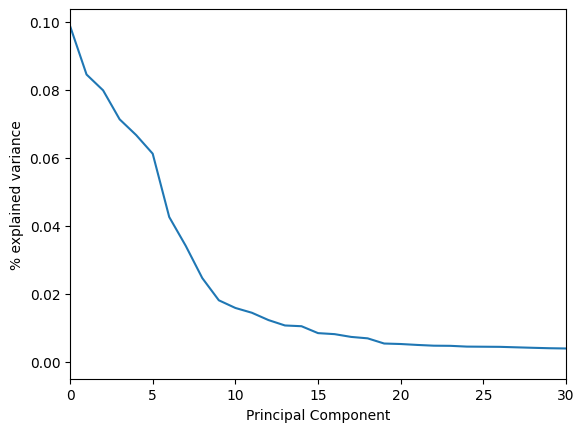

In [216]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');
plt.xlim(0,30)

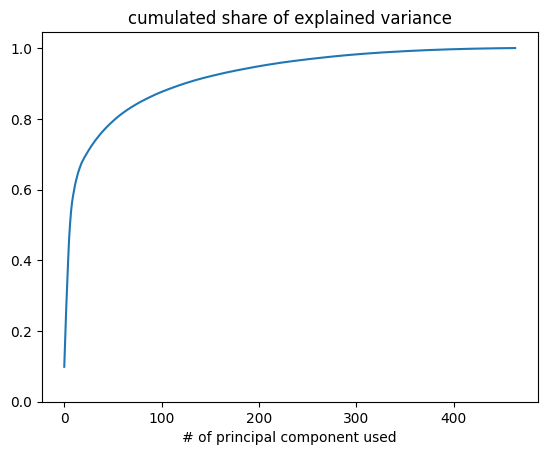

In [217]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [218]:
pca=PCA(n_components=8).fit(X_proc)
X_proj8 = pca.transform(X_proc)
X_proj8= pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1,9)])

In [319]:
X_proj8

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Cluster
TCUID,,,,,,,,,
185037.0,-0.246791,-0.349485,0.985311,-0.500422,0.076007,-0.111893,-0.115526,-0.054198,4
236994.0,-0.276971,-0.548105,-0.607338,-0.063774,0.464115,-0.205220,-0.178392,-0.083355,3
185334.0,-0.072888,-0.021804,0.012172,0.082192,-0.027364,0.057759,0.332801,1.078909,6
203522.0,-0.070981,-0.022899,0.012501,0.079845,-0.025707,0.055246,0.308005,0.973970,6
244864.0,-0.130519,-0.077141,0.046759,0.507729,-0.644728,-0.407086,-0.142707,-0.040699,5
...,...,...,...,...,...,...,...,...,...
135872.0,-0.148114,-0.095073,0.057573,0.623865,-0.800305,-0.512556,-0.184898,-0.085230,5
232457.0,-0.075616,-0.041703,0.017214,0.107209,-0.040028,0.074590,0.948442,-0.342360,6
247962.0,-0.123451,-0.076849,0.042579,0.346402,-0.227911,0.796021,-0.228476,-0.080987,6


In [219]:

X_comp8

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
TCUID,,,,,,,,
185037.0,-0.246791,-0.349485,0.985311,-0.500422,0.076007,-0.111893,-0.115526,-0.054198
236994.0,-0.276971,-0.548105,-0.607338,-0.063774,0.464115,-0.205220,-0.178392,-0.083355
185334.0,-0.072888,-0.021804,0.012172,0.082192,-0.027364,0.057759,0.332801,1.078909
203522.0,-0.070981,-0.022899,0.012501,0.079845,-0.025707,0.055246,0.308005,0.973970
244864.0,-0.130519,-0.077141,0.046759,0.507729,-0.644728,-0.407086,-0.142707,-0.040699
...,...,...,...,...,...,...,...,...
135872.0,-0.148114,-0.095073,0.057573,0.623865,-0.800305,-0.512556,-0.184898,-0.085230
232457.0,-0.075616,-0.041703,0.017214,0.107209,-0.040028,0.074590,0.948442,-0.342360
247962.0,-0.123451,-0.076849,0.042579,0.346402,-0.227911,0.796021,-0.228476,-0.080987


In [318]:
X_comp8 = pca.components_
X_comp8.shape[1]+1
# X_comp8 = pd.DataFrame(X_comp8.T, columns=[f'PC{i}' 
#                     for i in range(1,X_comp8.shape[1]+1)]
#                       ,index=dX_proc.columns)
# X_comp8

465

KNN

In [231]:
X_proj8

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
TCUID,,,,,,,,
185037.0,-0.246791,-0.349485,0.985311,-0.500422,0.076007,-0.111893,-0.115526,-0.054198
236994.0,-0.276971,-0.548105,-0.607338,-0.063774,0.464115,-0.205220,-0.178392,-0.083355
185334.0,-0.072888,-0.021804,0.012172,0.082192,-0.027364,0.057759,0.332801,1.078909
203522.0,-0.070981,-0.022899,0.012501,0.079845,-0.025707,0.055246,0.308005,0.973970
244864.0,-0.130519,-0.077141,0.046759,0.507729,-0.644728,-0.407086,-0.142707,-0.040699
...,...,...,...,...,...,...,...,...
135872.0,-0.148114,-0.095073,0.057573,0.623865,-0.800305,-0.512556,-0.184898,-0.085230
232457.0,-0.075616,-0.041703,0.017214,0.107209,-0.040028,0.074590,0.948442,-0.342360
247962.0,-0.123451,-0.076849,0.042579,0.346402,-0.227911,0.796021,-0.228476,-0.080987


In [221]:
# Fit K-means
km = KMeans(n_clusters=7)
km.fit(X_proj8)

KMeans(n_clusters=7)

In [222]:
km.cluster_centers_.shape

(7, 8)

In [223]:
km.labels_

array([4, 3, 6, ..., 6, 5, 5], dtype=int32)

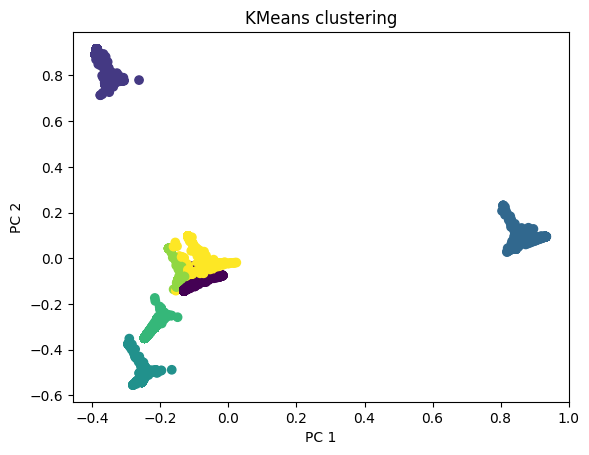

In [224]:
plt.scatter(X_proj8.iloc[:,0], X_proj8.iloc[:,1], c=km.labels_)
plt.title('KMeans clustering'); plt.xlabel('PC 1'); plt.ylabel('PC 2');

Text(0.5, 0, 'k cluster number')

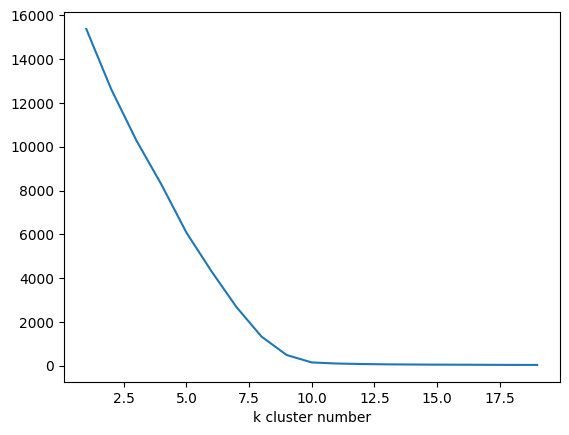

In [220]:
inertias = []
ks = range(1,20)

for k in ks:
    km_test = KMeans(n_clusters=k).fit(X_proj8)
    inertias.append(km_test.inertia_)

plt.plot(ks, inertias)
plt.xlabel('k cluster number')

Example of Prediction

In [200]:
dX_proc.iloc[0]

Abrasive product manufacturing                                    0.0
Accounting, tax preparation, bookkeeping, and payroll services    0.0
Adhesive manufacturing                                            0.0
Advertising and related services                                  0.0
Air and gas compressor manufacturing                              0.0
                                                                 ... 
Sector_Industrials                                                0.0
Sector_Information Technology                                     0.0
Sector_Materials                                                  0.0
Sector_Real Estate                                                0.0
Sector_Utilities                                                  0.0
Name: 185037.0, Length: 464, dtype: float64

Transform vector into a PCA projection

In [233]:
X_new=pca.transform(np.array(dX_proc.iloc[0]).reshape(1,-1))
X_new=pd.DataFrame(X_new,columns=X_proj8.columns)
X_new

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.246791,-0.349485,0.985311,-0.500422,0.076007,-0.111893,-0.115526,-0.054198


In [234]:
km.predict(X_new)

array([4], dtype=int32)

In [235]:
km.predict(X_proj8)

array([4, 3, 6, ..., 6, 5, 5], dtype=int32)

In [236]:
len(km.predict(X_proj8))

16639

In [237]:
X_proj8

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
TCUID,,,,,,,,
185037.0,-0.246791,-0.349485,0.985311,-0.500422,0.076007,-0.111893,-0.115526,-0.054198
236994.0,-0.276971,-0.548105,-0.607338,-0.063774,0.464115,-0.205220,-0.178392,-0.083355
185334.0,-0.072888,-0.021804,0.012172,0.082192,-0.027364,0.057759,0.332801,1.078909
203522.0,-0.070981,-0.022899,0.012501,0.079845,-0.025707,0.055246,0.308005,0.973970
244864.0,-0.130519,-0.077141,0.046759,0.507729,-0.644728,-0.407086,-0.142707,-0.040699
...,...,...,...,...,...,...,...,...
135872.0,-0.148114,-0.095073,0.057573,0.623865,-0.800305,-0.512556,-0.184898,-0.085230
232457.0,-0.075616,-0.041703,0.017214,0.107209,-0.040028,0.074590,0.948442,-0.342360
247962.0,-0.123451,-0.076849,0.042579,0.346402,-0.227911,0.796021,-0.228476,-0.080987


In [238]:
X_proj8['Cluster']=km.predict(X_proj8)

In [239]:
X_proj8['Cluster']

TCUID
185037.0    4
236994.0    3
185334.0    6
203522.0    6
244864.0    5
           ..
135872.0    5
232457.0    6
247962.0    6
234309.0    5
239643.0    5
Name: Cluster, Length: 16639, dtype: int32

Add Climate Score Column

In [242]:
dz=pd.read_csv("/Users/nadirgmira/code/carbon-forecast/raw_data/all_features_with_sectorrev.csv")

dpiv=dz[['TCUID','climate_strategy_scoreFY2022',
 'climate_strategy_scoreFY2021',
 'climate_strategy_scoreFY2020',
 'climate_strategy_scoreFY2019',
 'climate_strategy_scoreFY2018',
 'climate_strategy_scoreFY2017',
 'climate_strategy_scoreFY2016',
 'climate_strategy_scoreFY2015',
 'climate_strategy_scoreFY2014',
 'climate_strategy_scoreFY2013']]

dpiv.columns= (['TCUID']+
               [int(k.strip("climate_strategy_scoreFY"))
                for k in dpiv.columns 
                if "climate_strategy_scoreFY" in k])


dpiv.set_index('TCUID',inplace=True)
               
import itertools
dpiv_1=pd.DataFrame(index=pd.MultiIndex.from_product([dpiv.index,dpiv.columns], names=["TCUID", "Years"]),columns=['Climate Score'])

for k, l in itertools.product(list(dpiv.index),list(dpiv.columns)):
    dpiv_1.loc[(k,l),dpiv_1.columns[0]]=dpiv.loc[k,l]

dpiv_1



Climate Score
TCUID    Years              
185037.0 2022            NaN
         2021            NaN
         2020            NaN
         2019            NaN
         2018            NaN
...                      ...
239643.0 2017            NaN
         2016            NaN
         2015            NaN
         2014            NaN
         2013            NaN

[166470 rows x 1 columns]

In [244]:
dpiv_2=dpiv_1.xs(2020, level="Years")
dpiv_2

,Climate Score
TCUID,
185037.0,NaN
236994.0,NaN
185334.0,8.0
203522.0,NaN
244864.0,NaN
...,...
135872.0,0.0
232457.0,NaN
247962.0,NaN


In [246]:
X_proj8

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Cluster
TCUID,,,,,,,,,
185037.0,-0.246791,-0.349485,0.985311,-0.500422,0.076007,-0.111893,-0.115526,-0.054198,4
236994.0,-0.276971,-0.548105,-0.607338,-0.063774,0.464115,-0.205220,-0.178392,-0.083355,3
185334.0,-0.072888,-0.021804,0.012172,0.082192,-0.027364,0.057759,0.332801,1.078909,6
203522.0,-0.070981,-0.022899,0.012501,0.079845,-0.025707,0.055246,0.308005,0.973970,6
244864.0,-0.130519,-0.077141,0.046759,0.507729,-0.644728,-0.407086,-0.142707,-0.040699,5
...,...,...,...,...,...,...,...,...,...
135872.0,-0.148114,-0.095073,0.057573,0.623865,-0.800305,-0.512556,-0.184898,-0.085230,5
232457.0,-0.075616,-0.041703,0.017214,0.107209,-0.040028,0.074590,0.948442,-0.342360,6
247962.0,-0.123451,-0.076849,0.042579,0.346402,-0.227911,0.796021,-0.228476,-0.080987,6


In [247]:
dfinal=X_proj8.join(dpiv_2)
dfinal

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Cluster,Climate Score
TCUID,,,,,,,,,,
185037.0,-0.246791,-0.349485,0.985311,-0.500422,0.076007,-0.111893,-0.115526,-0.054198,4,NaN
236994.0,-0.276971,-0.548105,-0.607338,-0.063774,0.464115,-0.205220,-0.178392,-0.083355,3,NaN
185334.0,-0.072888,-0.021804,0.012172,0.082192,-0.027364,0.057759,0.332801,1.078909,6,8.0
203522.0,-0.070981,-0.022899,0.012501,0.079845,-0.025707,0.055246,0.308005,0.973970,6,NaN
244864.0,-0.130519,-0.077141,0.046759,0.507729,-0.644728,-0.407086,-0.142707,-0.040699,5,NaN
...,...,...,...,...,...,...,...,...,...,...
135872.0,-0.148114,-0.095073,0.057573,0.623865,-0.800305,-0.512556,-0.184898,-0.085230,5,0.0
232457.0,-0.075616,-0.041703,0.017214,0.107209,-0.040028,0.074590,0.948442,-0.342360,6,NaN
247962.0,-0.123451,-0.076849,0.042579,0.346402,-0.227911,0.796021,-0.228476,-0.080987,6,NaN


In [251]:
dgroup=dfinal[['Cluster','Climate Score']].groupby(by='Cluster').agg(['count','mean', 'min',
                                                                      'max','std'])


In [299]:
dgroup

Climate Score                                  
                count       mean  min    max        std
Cluster                                                
0                 703  11.229018  0.0  100.0  23.877839
1                1085  11.798157  0.0  100.0  27.029518
2                1483  14.970330  0.0  100.0  28.249404
3                1109  13.931470  0.0  100.0  28.813555
4                1146  15.719895  0.0  100.0  28.912654
5                 828   8.545894  0.0  100.0  23.870602
6                2374  19.687869  0.0  100.0  32.655681

In [261]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 4.4 MB/s eta 0:00:00a 0:00:01


In [262]:
import seaborn as sns

In [265]:
dfinal

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Cluster,Climate Score
TCUID,,,,,,,,,,
185037.0,-0.246791,-0.349485,0.985311,-0.500422,0.076007,-0.111893,-0.115526,-0.054198,4,NaN
236994.0,-0.276971,-0.548105,-0.607338,-0.063774,0.464115,-0.205220,-0.178392,-0.083355,3,NaN
185334.0,-0.072888,-0.021804,0.012172,0.082192,-0.027364,0.057759,0.332801,1.078909,6,8.0
203522.0,-0.070981,-0.022899,0.012501,0.079845,-0.025707,0.055246,0.308005,0.973970,6,NaN
244864.0,-0.130519,-0.077141,0.046759,0.507729,-0.644728,-0.407086,-0.142707,-0.040699,5,NaN
...,...,...,...,...,...,...,...,...,...,...
135872.0,-0.148114,-0.095073,0.057573,0.623865,-0.800305,-0.512556,-0.184898,-0.085230,5,0.0
232457.0,-0.075616,-0.041703,0.017214,0.107209,-0.040028,0.074590,0.948442,-0.342360,6,NaN
247962.0,-0.123451,-0.076849,0.042579,0.346402,-0.227911,0.796021,-0.228476,-0.080987,6,NaN


In [297]:
dfinal=dfinal.dropna()

In [300]:
dgroup=dfinal[['Cluster','Climate Score']].groupby(by='Cluster').agg(['count','mean', 'min',
                                                                      'max','std'])
dgroup

Climate Score                                  
                count       mean  min    max        std
Cluster                                                
0                 703  11.229018  0.0  100.0  23.877839
1                1085  11.798157  0.0  100.0  27.029518
2                1483  14.970330  0.0  100.0  28.249404
3                1109  13.931470  0.0  100.0  28.813555
4                1146  15.719895  0.0  100.0  28.912654
5                 828   8.545894  0.0  100.0  23.870602
6                2374  19.687869  0.0  100.0  32.655681

In [309]:
dfinal_trunc=dfinal['Cluster']
dfinal_trunc

TCUID
185334.0    6
237961.0    6
213896.0    3
184852.0    4
234120.0    6
           ..
44471.0     4
191075.0    2
135872.0    5
234309.0    5
239643.0    5
Name: Cluster, Length: 8728, dtype: int32

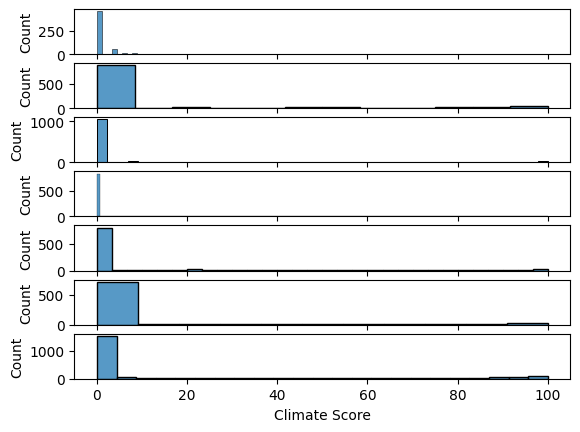

In [298]:
fig,axes=plt.subplots(7)
for l in range(0,K):
    sns.histplot(data=dfinal[dfinal['Cluster']==l], x="Climate Score",ax=axes[l])
    

Model Output

In [268]:
a=km.predict(X_new)
a[0]

4

In [294]:
X_proc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Models to export with pickle

In [313]:
X_proj8.drop(columns=['Cluster'])

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
TCUID,,,,,,,,
185037.0,-0.246791,-0.349485,0.985311,-0.500422,0.076007,-0.111893,-0.115526,-0.054198
236994.0,-0.276971,-0.548105,-0.607338,-0.063774,0.464115,-0.205220,-0.178392,-0.083355
185334.0,-0.072888,-0.021804,0.012172,0.082192,-0.027364,0.057759,0.332801,1.078909
203522.0,-0.070981,-0.022899,0.012501,0.079845,-0.025707,0.055246,0.308005,0.973970
244864.0,-0.130519,-0.077141,0.046759,0.507729,-0.644728,-0.407086,-0.142707,-0.040699
...,...,...,...,...,...,...,...,...
135872.0,-0.148114,-0.095073,0.057573,0.623865,-0.800305,-0.512556,-0.184898,-0.085230
232457.0,-0.075616,-0.041703,0.017214,0.107209,-0.040028,0.074590,0.948442,-0.342360
247962.0,-0.123451,-0.076849,0.042579,0.346402,-0.227911,0.796021,-0.228476,-0.080987


In [314]:
path="/Users/nadirgmira/code/carbon-forecast/carbon_forecast/pickle"


name= os.path.join(path,"col_transf.pkl")
model=our_tx(X).fit(X)

with open(name, "wb") as file:
    pickle.dump(model, file)    

    
name= os.path.join(path,"pca.pkl")
model=PCA(n_components=8).fit(X_proc)

with open(name, "wb") as file:
    pickle.dump(model, file)    
    
    
name= os.path.join(path,"kmeans.pkl")
model=KMeans(n_clusters=7).fit(X_proj8.drop(columns=['Cluster']))

with open(name, "wb") as file:
    pickle.dump(model, file)

       
    
name= os.path.join(path,"climate_score_stats_per_cluster.pkl")
with open(name, "wb") as file:
    dgroup.to_pickle(name)  
    

name= os.path.join(path,"TCUID_cluster_mapping.pkl")
with open(name, "wb") as file:
    dfinal_trunc.to_pickle(name)  


Climate Score                                  
                count       mean  min    max        std
Cluster                                                
0                 703  11.229018  0.0  100.0  23.877839
1                1085  11.798157  0.0  100.0  27.029518
2                1483  14.970330  0.0  100.0  28.249404
3                1109  13.931470  0.0  100.0  28.813555
4                1146  15.719895  0.0  100.0  28.912654
5                 828   8.545894  0.0  100.0  23.870602
6                2374  19.687869  0.0  100.0  32.655681

Workflow for predicting

In [312]:
X_proj8

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Cluster
TCUID,,,,,,,,,
185037.0,-0.246791,-0.349485,0.985311,-0.500422,0.076007,-0.111893,-0.115526,-0.054198,4
236994.0,-0.276971,-0.548105,-0.607338,-0.063774,0.464115,-0.205220,-0.178392,-0.083355,3
185334.0,-0.072888,-0.021804,0.012172,0.082192,-0.027364,0.057759,0.332801,1.078909,6
203522.0,-0.070981,-0.022899,0.012501,0.079845,-0.025707,0.055246,0.308005,0.973970,6
244864.0,-0.130519,-0.077141,0.046759,0.507729,-0.644728,-0.407086,-0.142707,-0.040699,5
...,...,...,...,...,...,...,...,...,...
135872.0,-0.148114,-0.095073,0.057573,0.623865,-0.800305,-0.512556,-0.184898,-0.085230,5
232457.0,-0.075616,-0.041703,0.017214,0.107209,-0.040028,0.074590,0.948442,-0.342360,6
247962.0,-0.123451,-0.076849,0.042579,0.346402,-0.227911,0.796021,-0.228476,-0.080987,6


In [ ]:
def pre_process(X):
    
    
    

In [ ]:
def pca_projection():
    
    
    return 
    

In [ ]:
def predict_score(X_new):
     
    a=km.predict(X_new)
    
    res=dfinal[['Cluster','Climate Score']][dfinal['Cluster']==a[0]]
    
    return [res['Climate Score'].mean(),res]


Statistical Analysis of the data: Carbon Intensity-Carbon Outright- Climate Score